In [2]:
import numpy as np
from numba import njit
from numba import prange
from numba import typed
from numba.typed import Dict
from numba.core import types
from numba.typed import List
from tqdm import tqdm
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
def plot_octree(pos, coms, centers_list, lengths_list, scale, mins = [0,0], save_fig = False):
    coms_list = np.unique(coms, axis = 0)
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.rcParams['font.family'] = 'courier new'
    plt.minorticks_on()
    plt.tick_params(axis = 'both', length = 3, direction = 'in', labeltop = 'on', labelright = 'on', 
                    which = 'both', right = True, top = True)
    # plotting
    ax.scatter(pos[:,0], pos[:,1], s = 0.5, c = 'darkslateblue')
    for i, com in enumerate(coms_list):
        mask = np.all(coms == com, axis = 1)
        x, y, z = centers_list[mask][0]
        length  = lengths_list[mask][0]
        x0, y0 = x - length/2, y - length/2
        rect = Rectangle((x0, y0), length, length, linewidth = 0.5, edgecolor = 'r', facecolor = 'none')
        plt.gca().add_patch(rect)
        ax.set_xlim(-scale+mins[0], scale)
        ax.set_ylim(-scale+mins[1], scale)
        ax.set_xlabel('x', size = 15)
        ax.set_ylabel('y', size = 15)
    if save_fig == True:
        filename = input('filename: ')
        plt.savefig(filename, format = 'png', transparent=True)
    plt.show()

@njit()
def compute_com(pos, mass):
    '''computes center of mass for a set of particles'''
    total_mass = np.sum(mass)
    com = np.sum(pos*mass, axis = 0)/total_mass
    
    return com, total_mass


@njit()
def compute_distance_sq(coms_list):
    x = coms_list[:, 0:1]
    y = coms_list[:, 1:2]
    z = coms_list[:, 2:3]
    delx = x.T-x
    dely = y.T-y
    delz = z.T-z
    return (delx**2+dely**2+delz**2)

def compute_softening(N):
    N5 = N/1e5
    return 0.017 * (N5)**(-0.23)

def load_galaxy(file_path, particle_number):
    galaxy = np.load(file_path)
    pos = np.ascontiguousarray(galaxy[:particle_number, 0:3])
    vel = np.ascontiguousarray(galaxy[:particle_number, 3:6])
    mass = np.ascontiguousarray(galaxy[:particle_number, 6:7])
    N = pos.shape[0]
    accel = np.ascontiguousarray(np.zeros((N,3)))
    softening = compute_softening(N)
    print('pos:', pos.shape, 'vel:', vel.shape, 'mass:', mass.shape, 'accel:', accel.shape, 'N:', N)
    return pos, vel, mass, accel, N, softening


def load_N_galaxies(file_paths):
    positions_list = []
    velocities_list = []
    masses_list = []
    
    # Load data from each file
    for file_path in file_paths:
        galaxy = np.load(file_path)
        positions_list.append(galaxy[:, 0:3])  # Nx3 positions
        velocities_list.append(galaxy[:, 3:6])  # Nx3 velocities
        masses_list.append(galaxy[:, 6:7])  # Nx1 masses

    # Concatenate along axis 0 to get final arrays
    pos = np.vstack(positions_list)  # (N, 3)
    vel = np.vstack(velocities_list)  # (N, 3)
    mass = np.vstack(masses_list)  # (N, 1)

    # Ensure arrays are contiguous in memory for performance
    pos = np.ascontiguousarray(pos)
    vel = np.ascontiguousarray(vel)
    mass = np.ascontiguousarray(mass)

    # Compute softening length based on total number of particles
    N = pos.shape[0]
    softening = compute_softening(N)
    accel = np.ascontiguousarray(np.zeros((N,3)))
    print('pos:', pos.shape, 'vel:', vel.shape, 'mass:', mass.shape, 'accel:', accel.shape, 'N:', N)

    return pos, vel, mass, accel, N, softening


@njit()
def subdivide_cell(pos, vel, mass, origin, length):
    '''subdivide simulation phase space into 8 octants'''
    # octdivide tree node
    masks = [(pos[:,0] > origin[0]) & (pos[:,1] > origin[1]) & (pos[:,2] > origin[2]),
             (pos[:,0] > origin[0]) & (pos[:,1] > origin[1]) & (pos[:,2] < origin[2]),
             (pos[:,0] < origin[0]) & (pos[:,1] > origin[1]) & (pos[:,2] > origin[2]),
             (pos[:,0] < origin[0]) & (pos[:,1] > origin[1]) & (pos[:,2] < origin[2]),
             (pos[:,0] < origin[0]) & (pos[:,1] < origin[1]) & (pos[:,2] > origin[2]),
             (pos[:,0] < origin[0]) & (pos[:,1] < origin[1]) & (pos[:,2] < origin[2]),
             (pos[:,0] > origin[0]) & (pos[:,1] < origin[1]) & (pos[:,2] > origin[2]),
             (pos[:,0] > origin[0]) & (pos[:,1] < origin[1]) & (pos[:,2] < origin[2])]
    # compute new centers
    centers = np.array([[origin[0] + length/4, origin[1] + length/4, origin[2] + length/4],
                        [origin[0] + length/4, origin[1] + length/4, origin[2] - length/4],
                        [origin[0] - length/4, origin[1] + length/4, origin[2] + length/4],
                        [origin[0] - length/4, origin[1] + length/4, origin[2] - length/4],
                        [origin[0] - length/4, origin[1] - length/4, origin[2] + length/4],
                        [origin[0] - length/4, origin[1] - length/4, origin[2] - length/4],
                        [origin[0] + length/4, origin[1] - length/4, origin[2] + length/4],
                        [origin[0] + length/4, origin[1] - length/4, origin[2] - length/4]])
    # generate arrays for storing data
    coms = np.zeros((pos.shape[0], 3))
    cell_masses = np.zeros((pos.shape[0], 1))
    centers_list = np.zeros((pos.shape[0], 3))
    lengths_list = np.zeros((pos.shape[0], 1))
    # iterate through each mask
    for i in prange(centers.shape[0]):
        mask = masks[i]
        center = centers[i]
        # skip empty masks
        if np.any(mask):
            # compute center of mass and total mass of cell
            com, cell_mass = compute_com(pos[mask], mass[mask])
            coms[mask] = com
            cell_masses[mask] = cell_mass
            centers_list[mask] = center
            lengths_list[mask] = length/2.0
            
    return coms, cell_masses, centers_list, lengths_list

@njit(parallel = True)
def recursive_oct_divide(pos, vel, mass, origin, box_length, depth):
    '''construct octree by recursive subdivision of tree cells to a specified depth'''
    # number of subdivisions
    depth = int(depth)
    # max number of particles per cell; cells are not subdivided if Nparticles < tolerance
    tolerance = 1
    # initial subdivision
    coms, cell_masses, centers_list, lengths_list = subdivide_cell(pos, vel, mass, origin, box_length)
    # number of tree depths
    for level in range(depth-1):
        # sum COM of each cell to create a unique tag
        com_sums = np.sum(coms, axis = 1)
        sums_list = np.unique(com_sums)
        # loop through each COM sum
        for i in prange(sums_list.shape[0]):
            # access all particles sharing a com (particles in the same cell)
            com_sum = sums_list[i]
            #idx = np.where(com_sums == com_sum)[0]
            mask = com_sums == com_sum
            # if number of particles > tolerance: subdivide into octants; else: skip
            if np.sum(mask) > tolerance:
                center = centers_list[mask][0]
                length = lengths_list[mask][0][0]
                octant_coms, octant_masses, octant_centers, octant_lengths = subdivide_cell(pos[mask], vel[mask], 
                                                                                      mass[mask], center, length)
                # create new unique tags for subdivided cells
                octant_com_sums = np.sum(octant_coms, axis = 1)
                octant_sums_list = np.unique(octant_com_sums)
                # loop through new cells and update tree variables
                for j in prange(octant_sums_list.shape[0]):
                    octant_com_sum = octant_sums_list[j]
                    new_mask = octant_com_sums == octant_com_sum
                    new_idx = np.where(mask)[0][new_mask]
                    coms[new_idx] = octant_coms[new_mask]
                    cell_masses[new_idx] = octant_masses[new_mask]
                    centers_list[new_idx] = octant_centers[new_mask]
                    lengths_list[new_idx] = octant_lengths[new_mask] 
 
            else:
                continue

    return coms, cell_masses, centers_list, lengths_list

@njit()
def traverse_octree(sum_com_dict, sums_list, r_sq, theta_sq, lenghts_list):
    sums_list_shape = sums_list.shape[0]
    lengths_list_sq = lengths_list**2
    acceptance_ratio = theta_sq*r_sq
    
    com_approximation_list = typed.List()
    particle_particle_list = typed.List()
    for _ in range(sums_list_shape):
        com_approximation_list.append(List.empty_list(np.int64))
        particle_particle_list.append(List.empty_list(np.int64))
        
    # loop through each cell via list of unique COMs
    for i in prange(sums_list_shape):
        current_cell = sums_list[i]
        idx = sum_com_dict[current_cell]
        # loop through upper triangle of all other COMs
        for j in prange(i+1,sums_list_shape):
            idx_neighbor = sum_com_dict[sums_list[j]]
            # check if (length <= theta*distance)**2 
            if lengths_list_sq[j] <= acceptance_ratio[i,j]:
                com_approximation_list[i].extend(idx_neighbor)
                com_approximation_list[j].extend(idx)
            else:
                particle_particle_list[i].extend(idx_neighbor)
                particle_particle_list[j].extend(idx)
   
    return com_approximation_list, particle_particle_list

@njit()
def traverse_octree_accel(pos, mass, accel, coms, coms_list, sums_list, sum_com_dict, cell_masses, lengths_list, theta_sq, softening):
    # unique COM sums
    lengths_list_sq = lengths_list**2
    total_force = np.zeros_like(accel)
    # loop through each cell via list of unique COMs
    for i in prange(coms_list.shape[0]):
        current_cell = sums_list[i]
        idx = sum_com_dict[current_cell]
        total_force.fill(0.0)
        # calculate gravitational force of cell onto itself if N>1
        if idx.shape[0] > 1:
            total_force[idx] += compute_self_accel(pos[idx], mass[idx], accel[idx], softening)
        # loop through all other COMs
        for j in prange(coms_list.shape[0]):
            idx_neighbor = sum_com_dict[sums_list[j]]
            # skip identical cells
            if (i == j):
                continue
            # compute distance approximation acceptance ratio length/distance
            com = coms_list[i]
            neighbor_com = coms_list[j]
            r_sq = np.sum((neighbor_com - com)**2)
            if lengths_list_sq[j] <= theta_sq*r_sq:
                total_force[idx] += compute_external_accel(pos[idx], coms[idx_neighbor], accel[idx], 
                                                           cell_masses[idx_neighbor], softening)
                
            else:
                total_force[idx] += compute_external_accel(pos[idx], pos[idx_neighbor], accel[idx], 
                                                           mass[idx_neighbor], softening)
        accel += total_force   
    
    return accel

@njit()
def compute_external_accel(pos, coms, accel, cell_masses, softening):
    '''compute gravitational acceleration via COM distance approximation
    delq has shape NxM where pos has shape Nx3 and com Mx3'''
    G = 1 
    N = pos.shape[0]
    delx =  coms[:, 0][None, :] - pos[:, 0][:, None]
    dely =  coms[:, 1][None, :] - pos[:, 1][:, None]
    delz =  coms[:, 2][None, :] - pos[:, 2][:, None]     
    
    r = (delx**2 + dely**2 + delz**2 + softening**2)**(-1.5)

    accel[:, 0:1] += np.sum( (G*(delx * r)*cell_masses[:,0] ), axis = 1).reshape(pos.shape[0], 1)
    accel[:, 1:2] += np.sum( (G*(dely * r)*cell_masses[:,0] ), axis = 1).reshape(pos.shape[0], 1)
    accel[:, 2:3] += np.sum( (G*(delz * r)*cell_masses[:,0] ), axis = 1).reshape(pos.shape[0], 1)
    
    return accel

@njit()
def compute_self_accel(pos, mass, accel, softening):
    '''this function returns the gravitational acceleration from orbiting masses'''
    G = 1
    # seperate position into x,y,z components
    x = pos[:, 0:1]
    y = pos[:, 1:2]
    z = pos[:, 2:3]
    # calculate particle-particle seperations
    delx = x.T - x
    dely = y.T - y
    delz = z.T - z
    delr = np.sqrt(delx**2 + dely**2 + delz**2 + softening**2)
    r = delr**(-3)
    # calculate acceleration
    accel[:, 0:1] += G * np.dot((delx * r), mass)
    accel[:, 1:2] += G * np.dot((dely * r), mass)
    accel[:, 2:3] += G * np.dot((delz * r), mass)
    
    return accel

def construct_numba_dict(com_sums, sums_list):
    sum_com_dict = Dict.empty(
        key_type=types.float64,  
        value_type=types.int64[:],  # Array of int64 indices
    )
    
    for com_sum in sums_list:
        sum_com_dict[com_sum] = np.where(com_sums == com_sum)[0]

    return sum_com_dict



## particle number c pour changer le nombre de particule paske par default la ya 50,000

In [11]:
pos, vel, mass, accel, N, softening = load_galaxy('galaxy50000.npy', particle_number = 5000)
theta_sq = 0.2**2

pos: (5000, 3) vel: (5000, 3) mass: (5000, 1) accel: (5000, 3) N: 5000


In [12]:
t0 = time()
coms, cell_masses, centers_list, lengths_list = recursive_oct_divide(pos, vel, mass, [0.,0.,0.], 200, 7)
coms_sum = np.sum(coms, axis = 1)
coms_list = np.unique(coms, axis = 0)
sums_list = np.sum(coms_list, axis = 1)
sum_com_dict = construct_numba_dict(coms_sum, sums_list)
r_sq = compute_distance_sq(coms_list)
t1 = time()
print(t1-t0)

0.07272982597351074


## scale c pour changer la tailles de axes

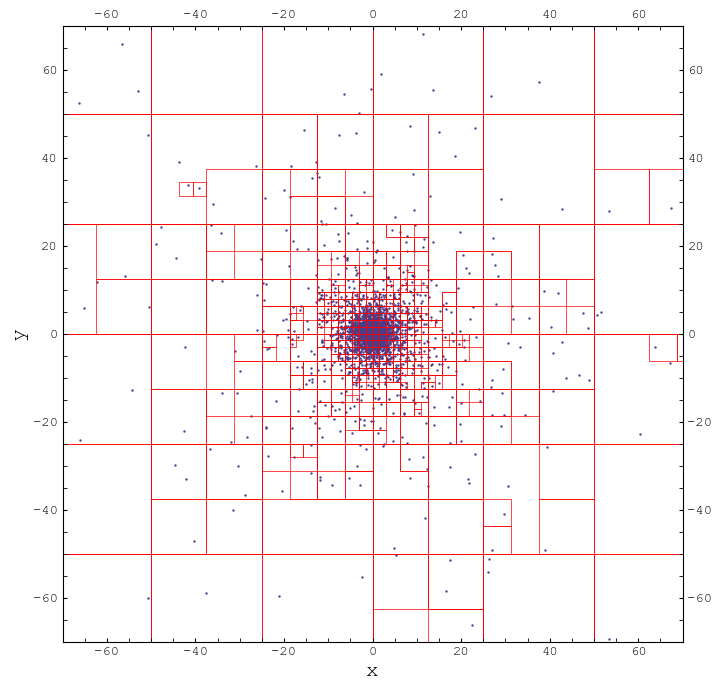

In [13]:
plot_octree(pos, coms, centers_list, lengths_list, scale = 70)

## ca c ma method pour traverser l'abre, ca output 2 liste de listes ou chaque sou liste correspond a les indeces j qui on une interaction avec indece i

In [17]:
t0 = time()
approximation_com, calculation_direct = traverse_octree(sum_com_dict, sums_list, r_sq, theta_sq, lengths_list)
t1 = time()
print(t1-t0)

0.36565518379211426
